In [15]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from scipy.stats import randint as sp_randint
import random 
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon as ex 
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import pylab
import csv
import time as t
import sys



"""Zcal is a supervised machine learning model which uses ensemble methods 
   to predict calibration solutions by learning from telescope
   sensor data and calibration solutions.
"""
arg=sys.argv

#Loading matrix data from .csv matrix
data=np.loadtxt('Train_Matrix.csv',delimiter=',',skiprows=1)

#Attaching index column to dada
IDX=np.arange(1,data.shape[0]+1) 
IDX1=np.matrix(IDX).transpose()
NewData=np.column_stack((IDX1,data))
Myscale=StandardScaler()
NewData[:,1:48]=Myscale.fit_transform(NewData[:,1:48]) 

#for i in range(10):
#    shuffle(NewData)


In [16]:
def Data_prep():
    #Normalizing data before splitting
    #Splitting Training and testing set using 80% and 20 % strattegy 
    X_Train,X_Test,Y_train,Y_test,=train_test_split(NewData[:,:48],NewData[:,48:76],test_size=0.2) 
    idtest= X_Test[:,0]  #Storing Index of testing set
    idtrain= X_Train[:,0] #Storing index  of training set
    return X_Train[:,1:],X_Test[:,1:], Y_train, Y_test    




RMS=[] #Empty set to append mse for each model with different parameters 
Ytest=Data_prep()[3]
def Decision_tree(Xtrain,Ytrain):
    n_iter_search=1500
    tuned_parameters = {'splitter': ['best','random']
                        ,"max_features":["log2","sqrt","auto"]
                        ,'min_samples_split':np.arange(30,60,5)
                        ,'min_samples_leaf':np.arange(7,14)
                        ,'max_depth':np.arange(700,1389,10)}
   
    #Randomised search paramater optimzation 
    Multreg=RandomizedSearchCV(DecisionTreeRegressor(random_state=0)
                               ,param_distributions=tuned_parameters
                               ,cv=10
                               ,n_iter=n_iter_search
                               ,n_jobs=-1
                               ,random_state=0)    

    #Start time for each training 
    start=t.time()
    Multreg.fit(Xtrain,Ytrain) #Fitting decision tree model
    t1=t.time()-start
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % (t1, n_iter_search))
    yMultreg=Multreg.predict(Data_prep()[1]) #Predicting with unseen testing set
    return yMultreg
YMultreg=Decision_tree(Data_prep()[0],Data_prep()[2])



def Random_forest(Xtrain,Ytrain):
    n_iter_search=1500
    grid={"n_estimators":np.arange(60,160,10)
          ,"max_features":["log2","sqrt","auto"]
          ,"max_depth":np.arange(700,1389,15)
          ,"min_samples_leaf":np.arange(7,50,10)}

    #Randomized search parameter optimization 
    RF=RandomizedSearchCV(RandomForestRegressor(random_state=0,oob_score =0)
                          ,param_distributions=grid
                          ,cv=10,n_iter=n_iter_search
                          ,n_jobs=-1,random_state=0)
    start=t.time()
    RF.fit(Xtrain,Ytrain)
    t2=t.time()-start
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % (t2, n_iter_search))

    rF_predict=RF.predict(Data_prep()[1]) #Predicting using unseen data 
    return rF_predict
RF_predict=Random_forest(Data_prep()[0],Data_prep()[2])



def K_NN(Xtrain,Ytrain):
    n_iter_search=1500
    KNNoptparam={"n_neighbors":np.arange(30,150,10)
                 ,"weights": ['uniform','distance']
                 ,"algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
                 ,"leaf_size":np.arange(30,150,15)
                 ,"p":[1,2,3]}

    #Randomized search parameter optimization 
    RF1=RandomizedSearchCV(KNeighborsRegressor()
                           ,param_distributions=KNNoptparam
                           ,cv=10
                           ,n_iter=n_iter_search
                           ,n_jobs=-1
                           ,random_state=0)
    start=t.time()
    RF1.fit(Xtrain,Ytrain)
    t3=t.time()-start
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % (t3, n_iter_search))
    rF1_predict=RF1.predict(Data_prep()[1])
    return rF1_predict
RF1_predict=RF_predict=K_NN(Data_prep()[0],Data_prep()[2])



def EXT_tree(Xtrain,Ytrain):
    n_iter_search=1500
    grid2={"n_estimators":np.arange(60,160,10)
           ,"max_features":["log2","sqrt","auto"]
           ,"max_depth":np.arange(700,1389,10)
           ,"min_samples_leaf":np.arange(7,50,10)}

    #Randomized search parameter optimization 
    RF3=RandomizedSearchCV(ExtraTreesRegressor(random_state=0,oob_score =0)
                           ,param_distributions=grid2
                           ,cv=10
                           ,n_iter=n_iter_search
                           ,n_jobs=-1
                           ,random_state=0)

    start=t.time()
    #MOdel fitting 
    RF3.fit(Xtrain,Ytrain) 
    t4=t.time()-start
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
           " parameter settings." % (t4, n_iter_search))
    #Predicting using unseen dataset 
    rF3_predict=RF3.predict(Data_prep()[1])
    return rF3_predict 
RF3_predict=EXT_tree(Data_prep()[0],Data_prep()[2])

            
#Hacky, assigning polarizations where x2 represents HH and x3  VV
x=range(np.shape(Data_prep()[2])[1])
x2=x[:-14] #HH
x3=x[-14:] #VV 
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
odd=x2[1::2] #HH phase,where odd is an index position for phase and even is index position for
                             #amplitude for both HH and VV.
even=x2[::2]  #HH amplitude
odd1=x3[1::2] #VV phase
even1=x3[::2] #VV Amplitude





#def Plot(Model_pred):
    #HH
#Dict= {'Decision-tree':Decision_tree(Data_prep()[0],Data_prep()[2])
#       ,'Random-Forest':Decision_tree(Data_prep()[0],Data_prep()[2])
#       ,'KNN':Decision_tree(Data_prep()[0],Data_prep()[2])
#       ,'EXT-tree':Decision_tree(Data_prep()[0],Data_prep()[2])}



RandomizedSearchCV took 219.95 seconds for 1500 candidates parameter settings.
RandomizedSearchCV took 4091.79 seconds for 1500 candidates parameter settings.
RandomizedSearchCV took 412.23 seconds for 1500 candidates parameter settings.
RandomizedSearchCV took 1577.03 seconds for 1500 candidates parameter settings.


In [17]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/home/simphiwe/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'pylab', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


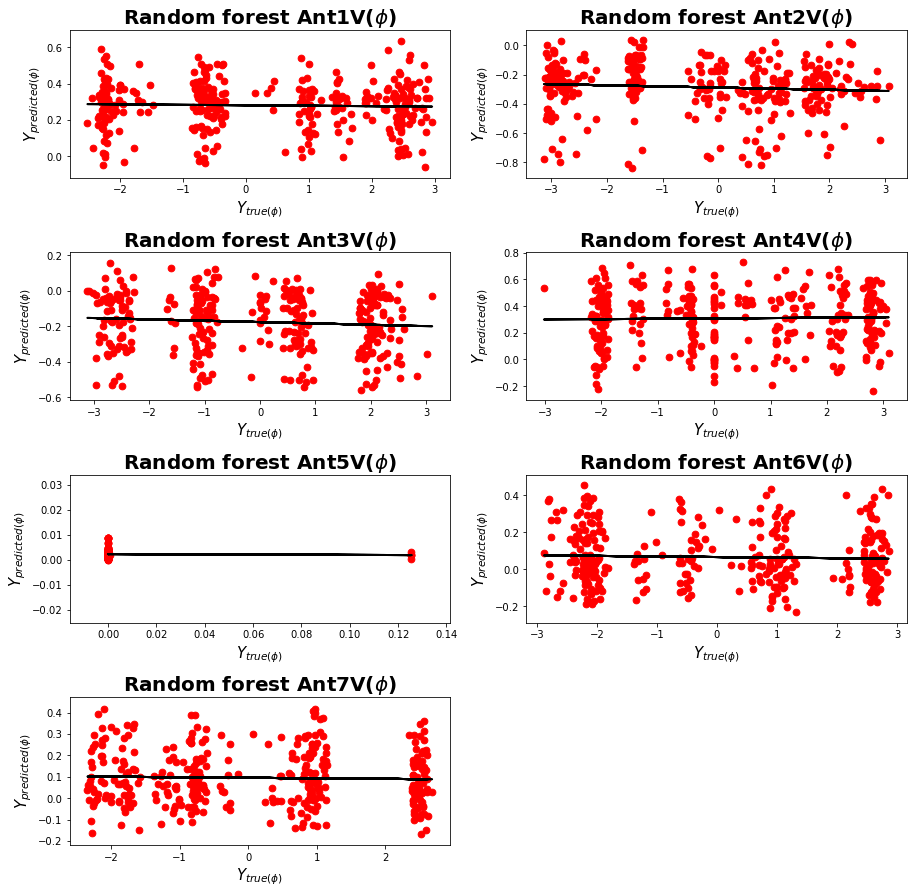

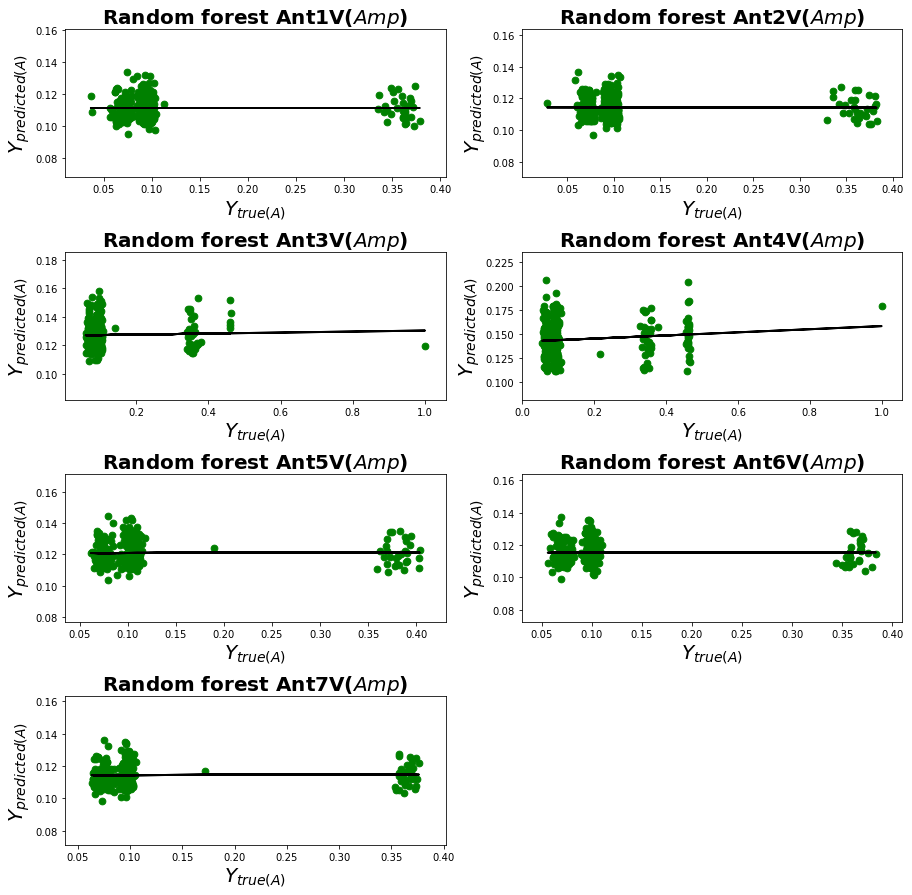

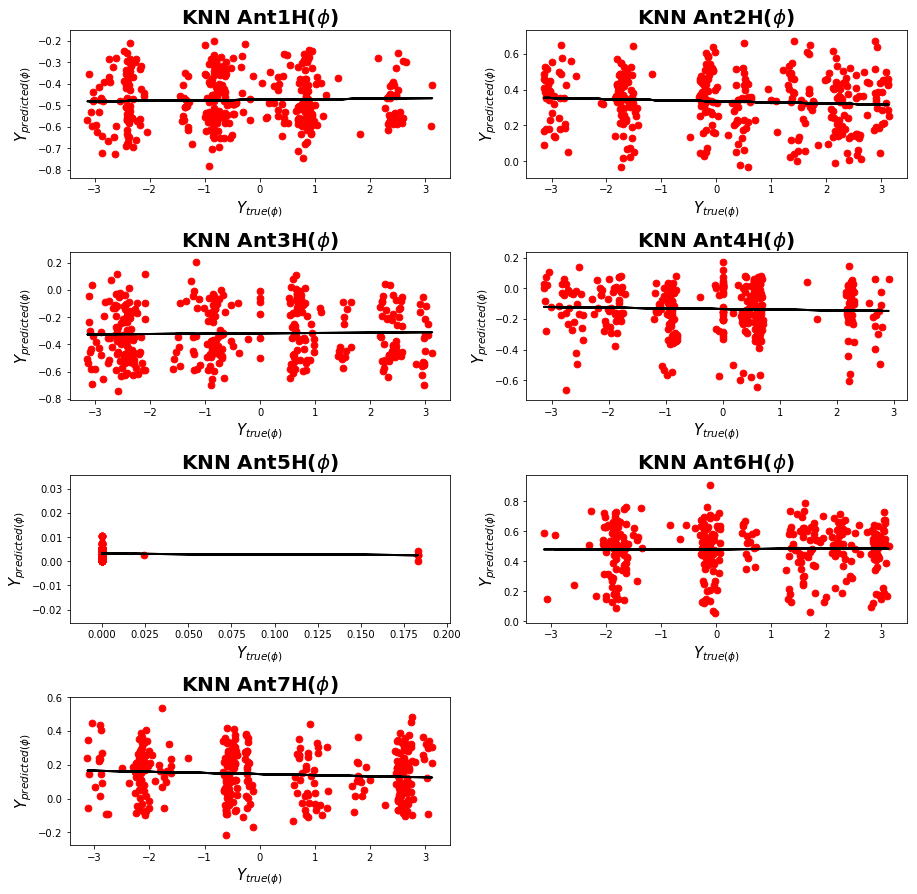

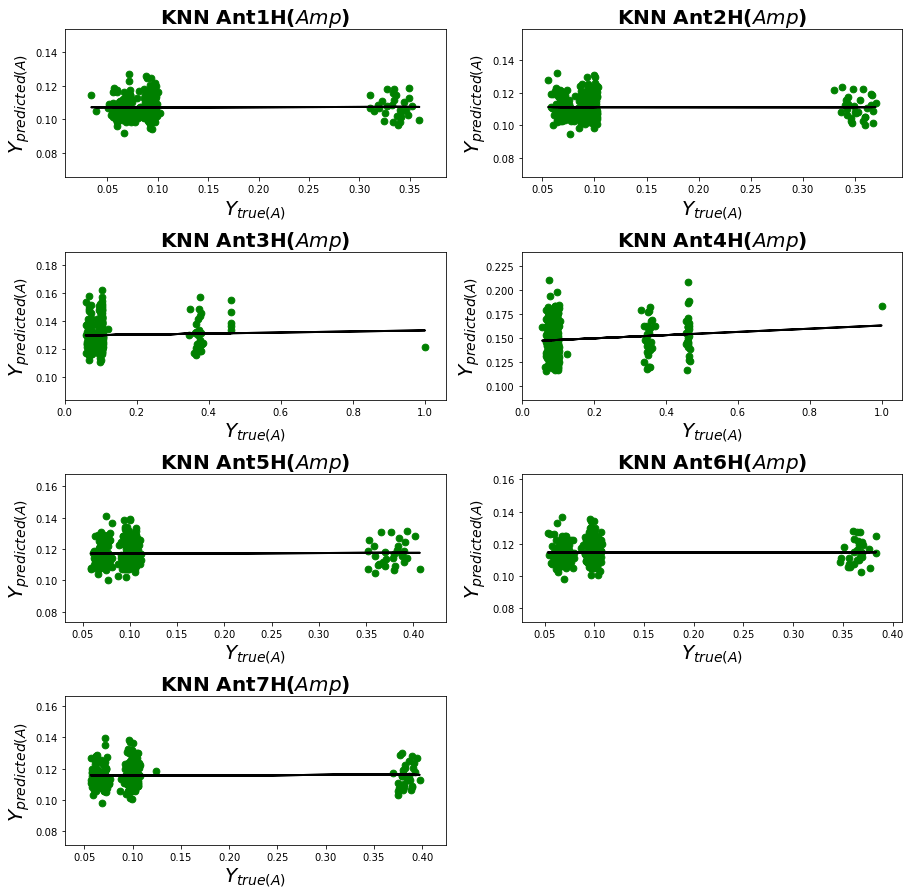

In [18]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for i in range(len(even)):
    plt.subplot(4,2,i+1)
    plt.scatter(np.ravel(Ytest[:,odd1[i]]),RF_predict[:, odd1[i]],c='r',marker='o',s=45)
    #Fitting a line betweeen the true and predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,odd1[i]]),RF_predict[:, odd1[i]])
    line = slope*np.ravel(Ytest[:,odd1[i]])+intercept
    plt.plot(np.ravel(Ytest[:,odd1[i]]),line,'k',lw=2)
    plt.ylabel('$Y_{predicted(\phi)}$',fontsize=15, fontweight='bold')
    plt.xlabel('$Y_{true(\phi)}$',fontsize=15, fontweight='bold')
    plt.title('Random forest Ant'+str(i+1)+ 'V'+'($\phi$)',fontsize=20,fontweight='bold')
    plt.savefig('RFVphase.eps')
    
    
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for i in range(len(even)):
    plt.subplot(4,2,i+1)
    plt.scatter(np.ravel(Ytest[:,even1[i]]),RF_predict[:, even1[i]],c='g',marker='o',s=45)
    #Fitting a line betweeen the true and predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,even1[i]]),RF_predict[:, even1[i]])
    line = slope*np.ravel(Ytest[:,even1[i]])+intercept
    plt.plot(np.ravel(Ytest[:,even1[i]]),line,'k',lw=2)
    plt.ylabel('$Y_{predicted(\phi)}$',fontsize=20, fontweight='bold')
    plt.ylabel('$Y_{predicted(A)}$',fontsize=20, fontweight='bold')
    plt.xlabel('$Y_{true(A)}$',fontsize=20, fontweight='bold')
    plt.title('Random forest Ant'+str(i+1)+'V'+'($Amp$)',fontsize=20,fontweight='bold')
    plt.savefig('RFVAmp.eps')
    
    
    
    

#KNN HH plot
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for i in range(len(even)):
    plt.subplot(4,2,i+1)
    plt.scatter(np.ravel(Ytest[:,odd[i]]),RF1_predict[:, odd[i]],c='r',marker='o',s=45)
    #Fitting a line betweeen the true and predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,odd[i]]),RF1_predict[:, odd[i]])
    line = slope*np.ravel(Ytest[:,odd[i]])+intercept
    plt.plot(np.ravel(Ytest[:,odd[i]]),line,'k',lw=2)
    plt.ylabel('$Y_{predicted(\phi)}$',fontsize=15, fontweight='bold')
    plt.xlabel('$Y_{true(\phi)}$',fontsize=15, fontweight='bold')
    plt.title('KNN Ant'+str(i+1)+'H'+'($\phi$)',fontsize=20,fontweight='bold')
    plt.savefig('KNNHphase.eps')
    
    
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for i in range(len(even)):
    plt.subplot(4,2,i+1)
    plt.scatter(np.ravel(Ytest[:,even[i]]),RF1_predict[:, even[i]],c='g',marker='o',s=45)
    #Fitting a line betweeen the true and predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,even[i]]),RF1_predict[:, even[i]])
    line = slope*np.ravel(Ytest[:,even[i]])+intercept
    plt.plot(np.ravel(Ytest[:,even[i]]),line,'k',lw=2)
    plt.ylabel('$Y_{predicted(\phi)}$',fontsize=20, fontweight='bold')
    plt.ylabel('$Y_{predicted(A)}$',fontsize=20, fontweight='bold')
    plt.xlabel('$Y_{true(A)}$',fontsize=20, fontweight='bold')
    plt.title('KNN Ant'+str(i+1)+'H'+'($Amp$)',fontsize=20,fontweight='bold')
    plt.savefig('KNNHAmp.eps')
    
    
    


Average explained variance is :   -0.0450242354342
Average explained variance is :   -0.0450242354342
Explained variance (Amp) :   [-0.03524271 -0.03365639 -0.05176482 -0.06102385 -0.03251857 -0.03342506
 -0.03399927]
Explained variance (Phase) :   [-0.05314494 -0.01514189 -0.06741739 -0.03301587 -0.04991215 -0.06097835
 -0.06909804]
Average  mean_squared_error is :   1.47812345175
 mean_squared_error is (Amp):   [ 0.04733755  0.0494117   0.07525953  0.09917551  0.05304395  0.05100594
  0.05459064]
 mean_squared_error is (Phase):   [ 1.3482246   1.74026239  1.73602713  1.33017584  0.00831841  1.60448861
  1.71226274]
Average  mean_absolute_error :  0.707827466953
mean_absolute_error (Amp):   [ 0.04733755  0.0494117   0.07525953  0.09917551  0.05304395  0.05100594
  0.05459064]
mean_absolute_error (Phase):   [ 1.3482246   1.74026239  1.73602713  1.33017584  0.00831841  1.60448861
  1.71226274]
Average  r2score_error is :   -0.0524663709446
mean_r2score_error (Amp):   [-0.03525858 -0.033

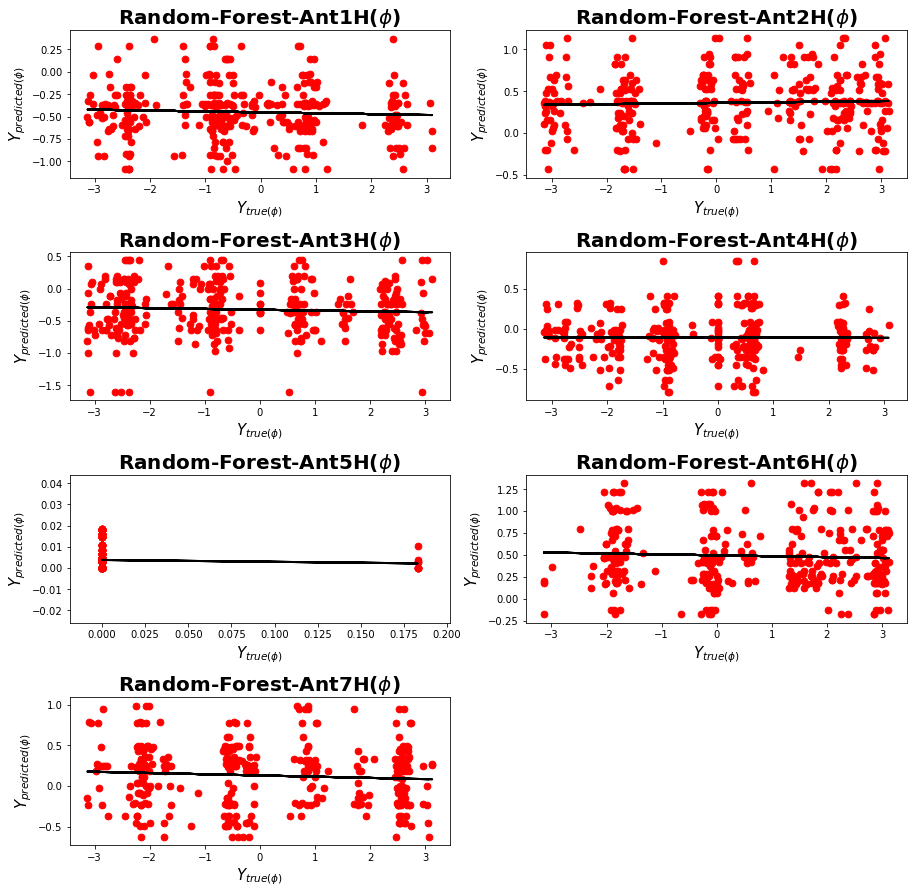

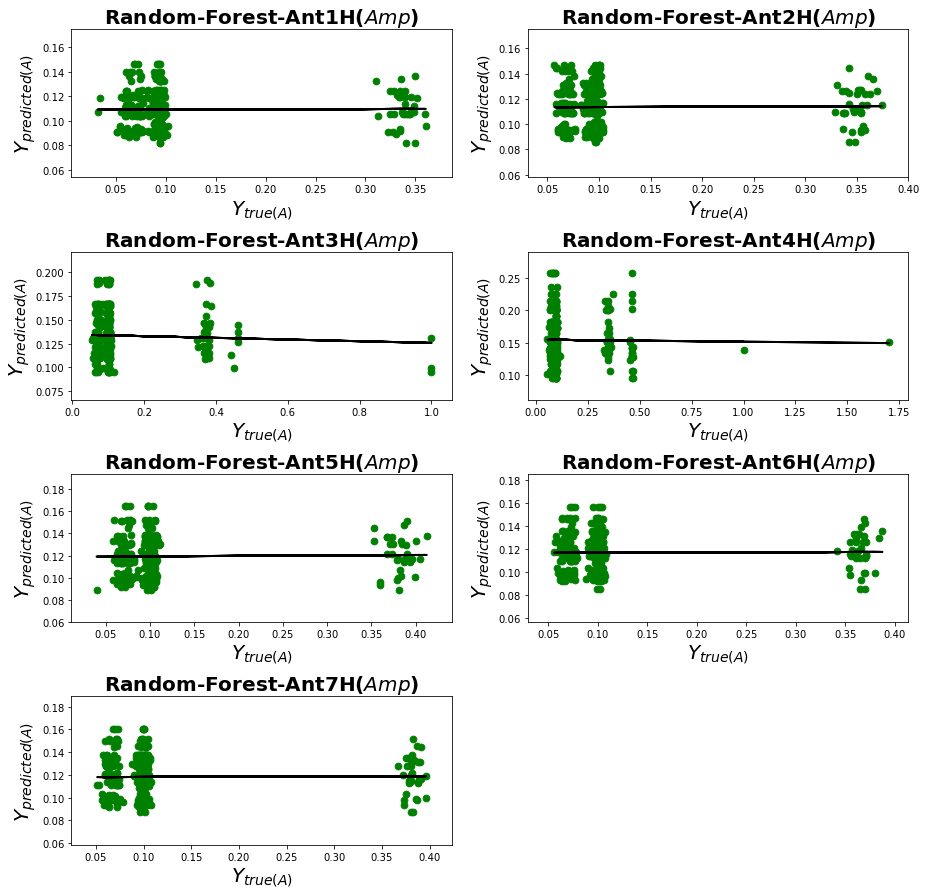

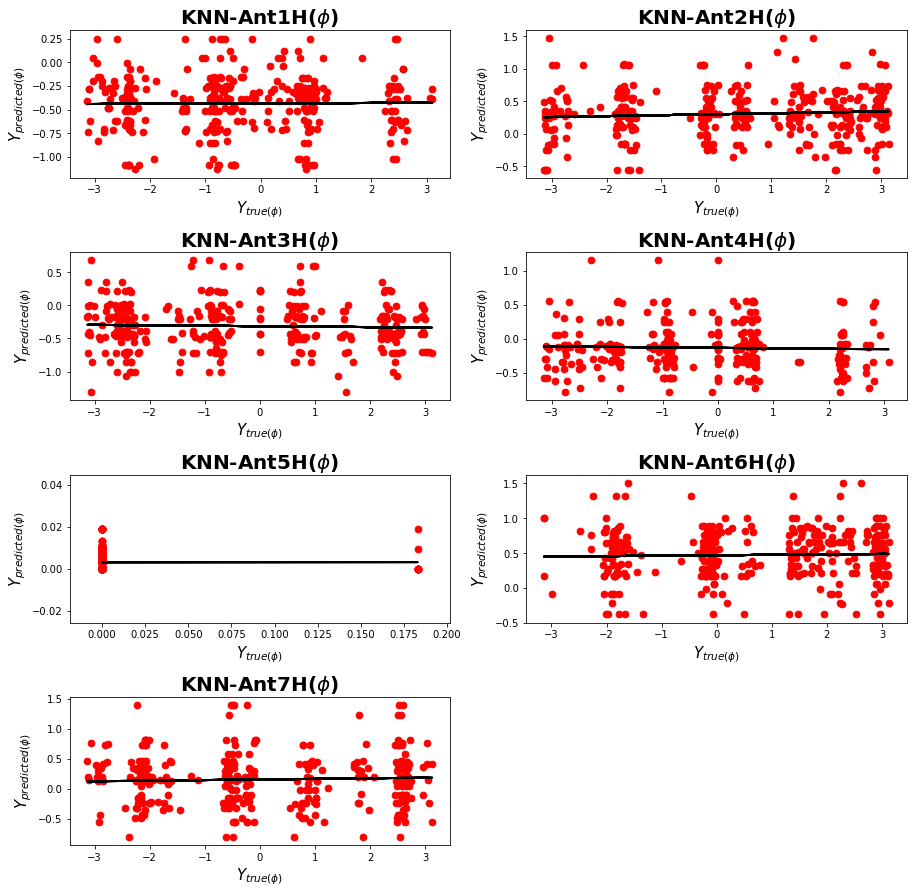

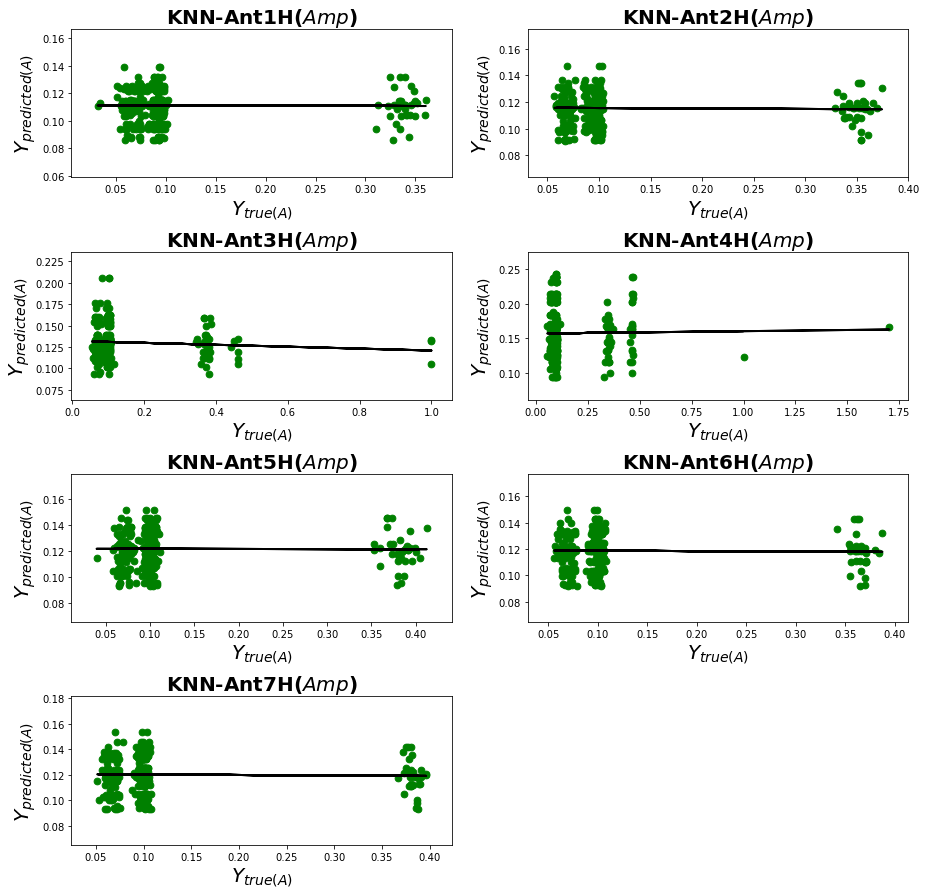

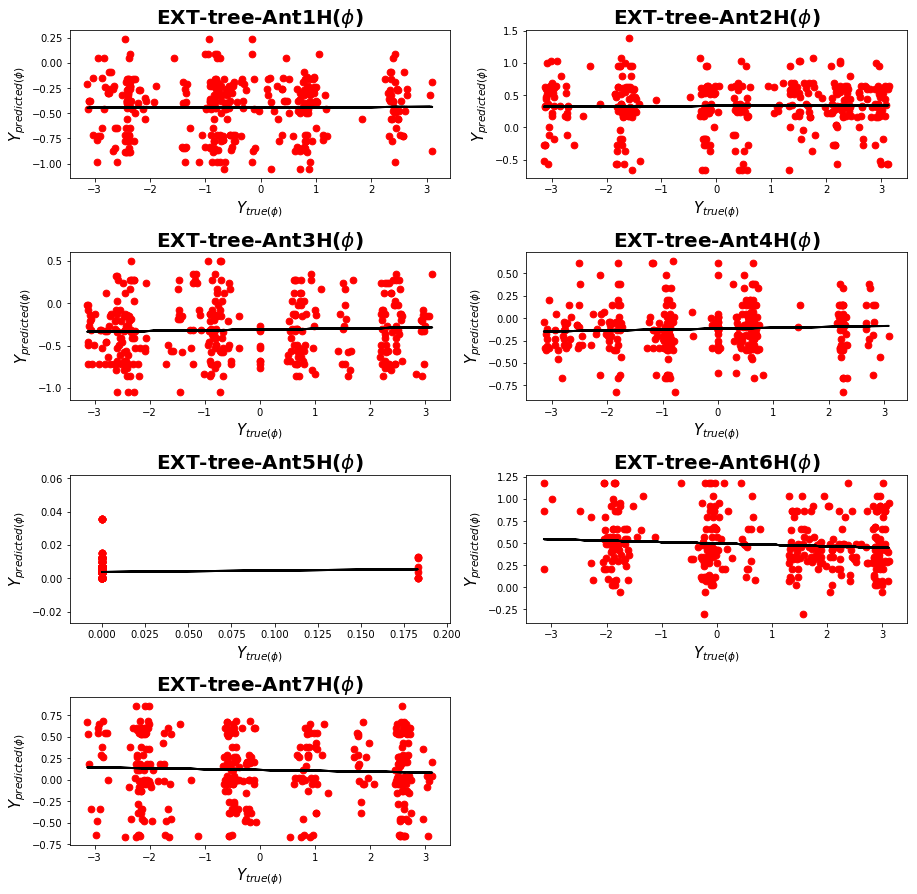

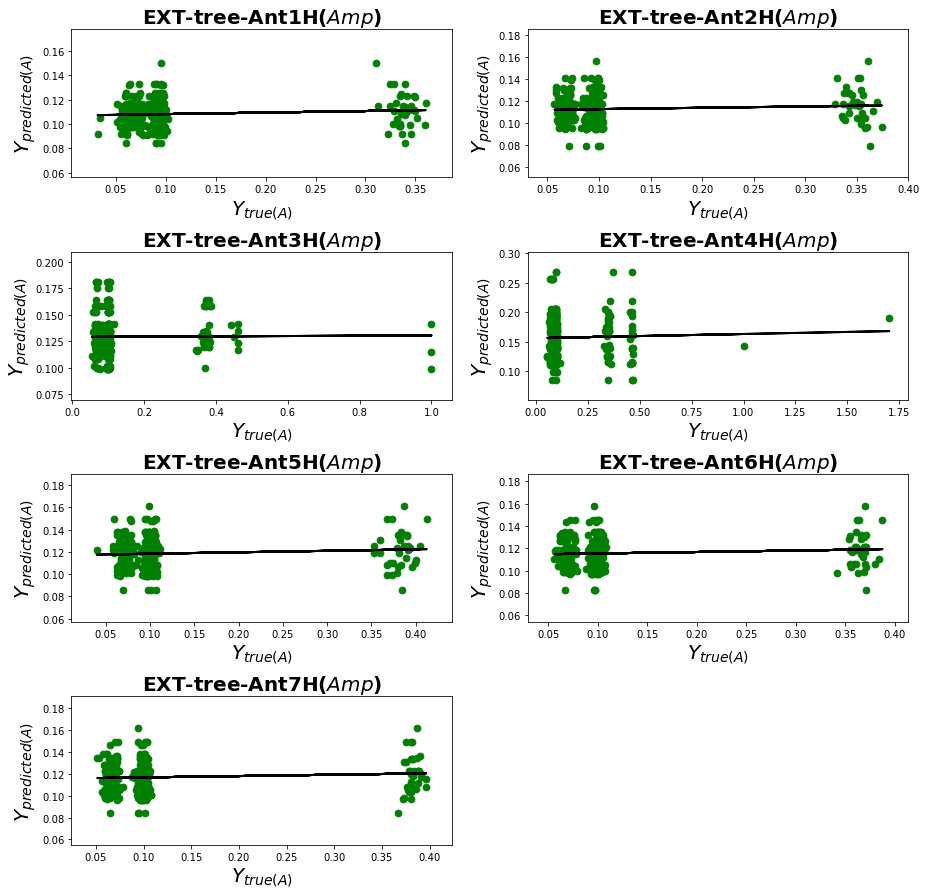

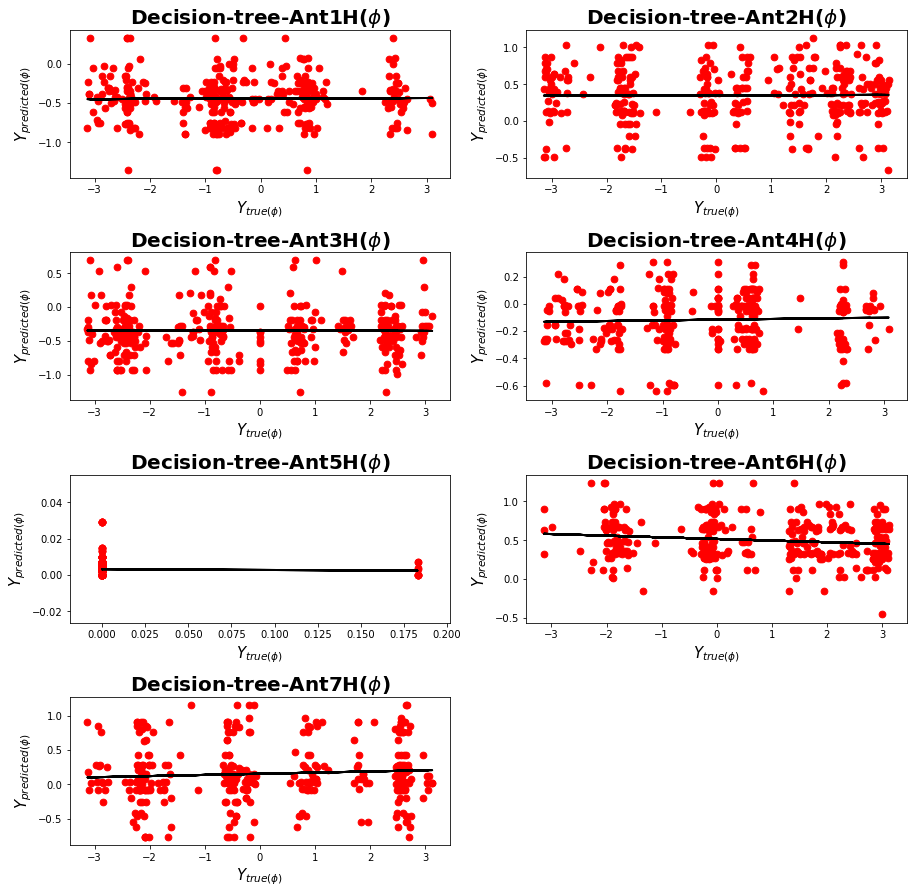

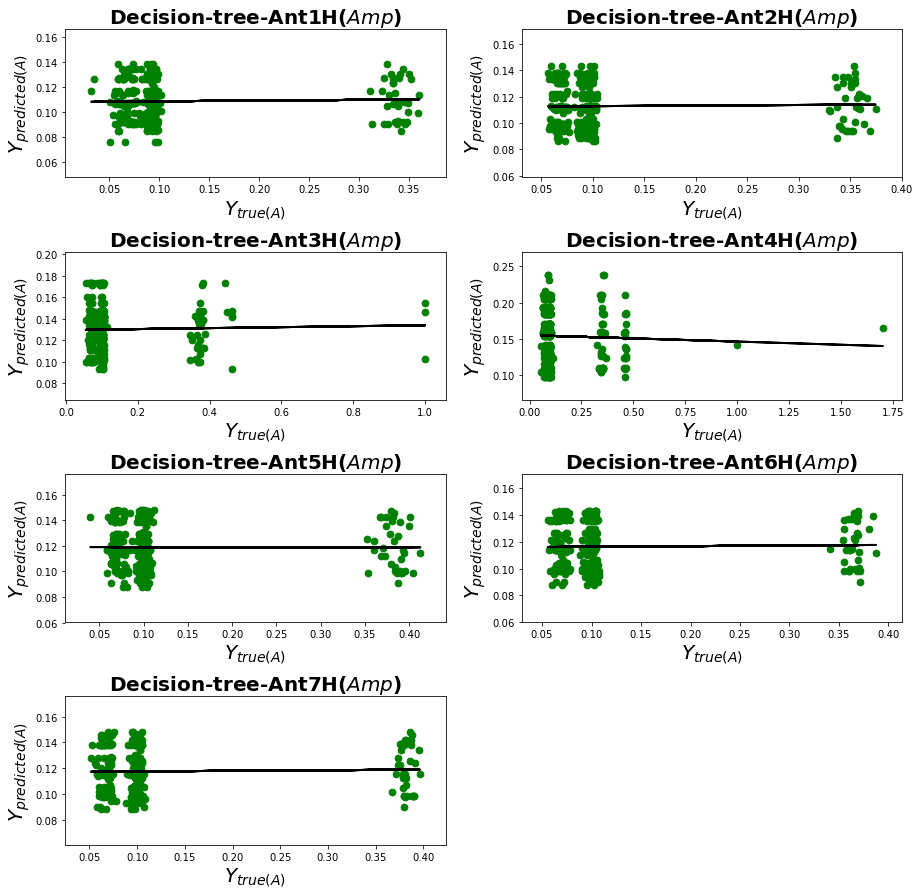

In [8]:
for Model,Model_pred in Dict.iteritems():
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5)
    for i in range(len(odd)):
        plt.subplot(4,2,i+1)
        plt.scatter(np.ravel(Ytest[:,odd[i]]),Model_pred[:, odd[i]],c='r',marker='o',s=45)
        #Fitting a line betweeen the true and predicted
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,odd[i]])
                                                          ,Model_pred[:, odd[i]])
        line = slope*np.ravel(Ytest[:,odd[i]])+intercept
        plt.plot(np.ravel(Ytest[:,odd[i]]),line,'k',lw=2)
        plt.ylabel('$Y_{predicted(\phi)}$',fontsize=15, fontweight='bold')
        plt.xlabel('$Y_{true(\phi)}$',fontsize=15, fontweight='bold')
        plt.title(Model+'-'+'Ant'+str(i+1)+'H'+'($\phi$)',fontsize=20,fontweight='bold')
        #plt.savefig(Model+'Hphase.eps')
    
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5)
    for i in range(len(even)):
        plt.subplot(4,2,i+1)
        plt.scatter(np.ravel(Ytest[:,even[i]]),Model_pred[:, even[i]],c='g',marker='o',s=45)
        #Fitting a line betweeen the true and predicted
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.ravel(Ytest[:,even[i]])
                                                          ,Model_pred[:, even[i]])
        line = slope*np.ravel(Ytest[:,even[i]])+intercept
        plt.plot(np.ravel(Ytest[:,even[i]]),line,'k',lw=2)
        plt.ylabel('$Y_{predicted(A)}$',fontsize=20, fontweight='bold')
        plt.xlabel('$Y_{true(A)}$',fontsize=20, fontweight='bold')
        plt.title(Model+'-'+'Ant'+str(i+1)+'H'+'($Amp$)',fontsize=20,fontweight='bold')
        #plt.savefig(Model+'Hamp.eps')
        
        
    # HH Model evaluation     %pylab inline

    print ("Average explained variance is :  ", (explained_variance_score(Ytest[:,x2],Model_pred[:,x2])) )
    print ("Average explained variance is :  ", (explained_variance_score(Ytest[:,x2],Model_pred[:,x2])) )
    print ("Explained variance (Amp) :  ", (explained_variance_score(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[::2]))
    print ("Explained variance (Phase) :  ", (explained_variance_score(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[1::2]))
    print ("Average  mean_squared_error is :  ", (mean_squared_error(Ytest[:,x2],Model_pred[:,x2])) )
    print (" mean_squared_error is (Amp):  ", (mean_absolute_error(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[::2]) )
    print (" mean_squared_error is (Phase):  ", (mean_absolute_error(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[1::2]) )
    print ("Average  mean_absolute_error : " ,(mean_absolute_error(Ytest[:,x2],Model_pred[:,x2])) )
    print ("mean_absolute_error (Amp):  ", (mean_absolute_error(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[::2]))
    print ("mean_absolute_error (Phase):  ", (mean_absolute_error(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[1::2]))
    print ("Average  r2score_error is :  ",(r2_score(Ytest[:,x2],Model_pred[:,x2],multioutput='variance_weighted'))) 
    print ("mean_r2score_error (Amp):  " ,(r2_score(Ytest[:,x2],Model_pred[:,x2] ,multioutput='raw_values')[::2]))
    print ("mean_r2score_error (Phase): ", (r2_score(Ytest[:,x2],Model_pred[:,x2],multioutput='raw_values')[1::2]))
    print ("--------------------------------------------------------------------------------------------------------\n")
    

   